# Read data from xml

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
import xml.etree.ElementTree as ET
from itertools import chain

In [3]:
def get_dynamic_data(xml_file):
    def process_interval(interval):
        for e in interval.findall('edge'):
            for lane in e.findall('lane'):            
                yield {
                    'begin': float(interval.get('begin')),
                    'lane_id': lane.get('id'),
                    'density': float(lane.get('density', 0)),
                    'speed': float(lane.get('speed', 0)),
                    'occupancy': float(lane.get('occupancy', 0))
                }

    def convert_to_csv(xml_file):
        root = ET.parse(xml_file).getroot()
        intervals = root.findall('interval')
        data = pd.DataFrame(chain(*map(process_interval, intervals)), columns=['begin', 'lane_id', 'density', 'speed','occupancy'])
        data['density'] = data.density / 1000 # convert from veh/km to veh/m
        data['flow'] = data['density'] * data['speed'] # add flow column
        return data
    
    return convert_to_csv(xml_file)

def get_static_data(xml_file):
    def process_edge(edge):
        for lane in edge.findall('lane'):            
            yield {
                'lane_id': lane.get('id'),
                'max_speed': float(lane.get('speed', 0)),
            }
    def convert_to_csv(xml_file):
        root = ET.parse(xml_file).getroot()
        edges = root.findall('edge')
        data = pd.DataFrame(chain(*map(process_edge, edges)), columns=['lane_id', 'max_speed'])
        return data
    return convert_to_csv(xml_file)

In [4]:
# Get data for 3 different models
data_default_lanes = get_dynamic_data('maryland/fundamental_out.xml')
data_platoons_lanes = get_dynamic_data('maryland/fundamental_out_platoons_model.xml')
data_gm_lanes = get_dynamic_data('maryland/fundamental_out_GM_model.xml')

In [9]:
lanes_data = get_static_data('maryland/moco.net.xml')

In [10]:
ALL_LANES = lanes_data.lane_id.values.tolist()

In [11]:
def get_lane_max_speed(lane_id):
    return float(lanes_data[lanes_data['lane_id'] == lane_id].max_speed)

In [12]:
data_default_lanes.describe()

,begin,density,speed,occupancy,flow
count,331680.00000,331680.000000,331680.000000,331680.000000,331680.000000
mean,7170.00000,0.012394,3.532547,4.862615,0.038310
std,4156.89212,0.036644,7.233093,15.011197,0.155996
min,0.00000,0.000000,0.000000,0.000000,0.000000
25%,3585.00000,0.000000,0.000000,0.000000,0.000000
50%,7170.00000,0.000000,0.000000,0.000000,0.000000
75%,10755.00000,0.003020,1.100000,1.040000,0.017676
max,14340.00000,0.200000,34.340000,100.000000,5.272000


In [13]:
data_platoons_lanes.describe()

,begin,density,speed,occupancy,flow
count,41460.0000,41460.000000,41460.000000,41460.000000,41460.000000
mean,1740.0000,0.005825,5.538335,2.053508,0.052511
std,1038.6655,0.016833,8.258314,6.317128,0.172762
min,0.0000,0.000000,0.000000,0.000000,0.000000
25%,840.0000,0.000000,0.000000,0.000000,0.000000
50%,1740.0000,0.000000,0.000000,0.000000,0.000000
75%,2640.0000,0.004350,11.190000,1.550000,0.048963
max,3480.0000,0.133330,31.270000,91.190000,3.545245


In [14]:
data_gm_lanes.describe()

,begin,density,speed,occupancy,flow
count,41460.0000,41460.000000,41460.000000,41460.000000,41460.000000
mean,1740.0000,0.003720,3.576780,1.476235,0.009292
std,1038.6655,0.015236,7.483844,6.681589,0.036052
min,0.0000,0.000000,0.000000,0.000000,0.000000
25%,840.0000,0.000000,0.000000,0.000000,0.000000
50%,1740.0000,0.000000,0.000000,0.000000,0.000000
75%,2640.0000,0.000740,0.400000,0.270000,0.008199
max,3480.0000,0.133330,32.160000,105.960000,1.275217


# Plot fundamental diagram

In [15]:
def get_fundamental(way_id, data, max_rho=0.20, verbose=True):
    lane = data.loc[way_id]
    # exclude max density flows
#     lane = lane[lane['density'] != max_rho]
    # rho_1 and Q_1
    rho_1, q_1 = lane.loc[lane.flow.idxmax()][['density', 'flow']]

    rho_max = max(max_rho, lane.density.max())
    
    # Get values of free flow
    free_flow = lane[lane.density.between(rho_1 * 3 / 8, rho_1 * 5 / 8)]
    try:
        rho_0, q_0 = free_flow.loc[free_flow.flow.idxmax()][['density', 'flow']]
    except ValueError:
        if verbose:
            print('There are no points in the interval of `free flow`: rho in [%.3f : %.3f]' % (rho_1 * 3 / 8, rho_1 * 5 / 8))
        rho_0, q_0 = rho_1, q_1
        
    # Get rho_2 and Q_2
    max_flow = lane.flow.max()
    max_density = lane.density.max()
    if max_flow == 0 or max_density == 0:
        q_2, rho_2 = 0., 0.
    else:
        most_distant_point = lane.loc[((lane.flow / lane.flow.max()).pow(2) + (lane.density / lane.density.max()).pow(2)).pow(1./2).idxmax()]
        q_2, rho_2 = most_distant_point.flow, most_distant_point.density
    
    if verbose:
        print('Q0:{:.3f}\nQ1:{:.3f}\nQ2:{:.3f}\nrho0:{:.3f}\nrho1:{:.3f}\nrho2:{:.3f}\nrho*:{:.3f}'.format(q_0, q_1, q_2, rho_0, rho_1, rho_2, rho_max))
        print('free_flow | {:3.3f}:{:3.3f}(rho_1)\nsync_flow | {:3.3f}(rho_1):{:3.3f}(rho_2)\njam_flow  | {:3.3f}(rho_2):{:3.3f}(rho_*)'.format(0, rho_1, rho_1, rho_2, rho_2, rho_max))
    
    return rho_0, rho_1, rho_2, rho_max, q_0, q_1, q_2

In [16]:
def plot_fundamental(way_id, data):
    rho_0, rho_1, rho_2, rho_max, q_0, q_1, q_2 = get_fundamental(way_id, data)
    lane = data.loc[way_id]
    
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 4))
    fig.suptitle('Way id: %s' % way_id)
    ax0.set_title('Fundamental diagram')
    ax0.set_xlabel('Density, veh/m')
    ax0.grid()
    ax0.set_ylabel('Flow, veh/s')
    ax0.scatter(lane.density, lane.flow)

    ax1.set_title('Optimal speed')
    ax1.set_xlabel('Density, veh/m')
    ax1.set_ylabel('V, m/s')
    ax1.grid()
    ax1.scatter(lane.density, lane.speed)
    
    for ax in [ax0, ax1]:
        ax.axvline(x=0, linestyle='-', c='r')
        ax.axvline(x=rho_1, linestyle='-', c='g')
        ax.axvline(x=rho_2, linestyle='--', c='b')
        ax.axvline(x=rho_max, linestyle='--', c='r')

    fig.tight_layout()
    return fig, ax0, ax1

In [17]:
def plot_hulls(way_id, data):
    rho_0, rho_1, rho_2, rho_max, q_0, q_1, q_2 = get_fundamental(way_id, data)
    lane = data.loc[way_id]
    points = lane[['density', 'speed']].values
    points[:2] > 0.01

## Average over the road 

In [18]:
# Get the data indexed by road and lane ids and time of detection
def average_over_lanes(data):
    t_data = data.copy()
    t_data[['road_id', 'lane_id']] = t_data.lane_id.str.rsplit('_', n=1, expand=True)
    return t_data.groupby(['road_id', 'begin']).mean(), data.groupby(['lane_id', 'begin']).mean()

In [19]:
data_default_roads, data_default_lanes = average_over_lanes(data_default_lanes)
data_platoons_roads, data_platoons_lanes = average_over_lanes(data_platoons_lanes)
data_gm_roads, data_gm_lanes = average_over_lanes(data_gm_lanes)

In [20]:
ALL_ROADS = data_default_roads.index.levels[0].tolist()

In [21]:
# Example
data_default_lanes.tail(5)

density  speed  occupancy      flow
lane_id  begin                                       
gneE17_1 14100.0  0.00195  13.36       0.94  0.026052
         14160.0  0.00000   0.00       0.00  0.000000
         14220.0  0.00000   0.00       0.00  0.000000
         14280.0  0.00000   0.00       0.00  0.000000
         14340.0  0.00090  13.38       0.43  0.012042

In [22]:
# Example
data_default_roads.tail()

density  speed  occupancy      flow
road_id    begin                                        
gneE17.147 14100.0  0.013498  2.840      6.740  0.025812
           14160.0  0.013116  2.484      6.482  0.031502
           14220.0  0.007376  2.832      3.674  0.022402
           14280.0  0.017148  2.020      8.512  0.025953
           14340.0  0.004526  5.798      2.230  0.029132

In [23]:
# Let's find the most loaded roads
data_default_roads.groupby('road_id').mean().sort_values('flow', ascending=False).head(5)

,density,speed,occupancy,flow
road_id,,,,
:290051915_0,0.086468,22.945292,2.449187,2.126359
:1688843682_0,0.139714,8.500854,4.346938,1.307794
:298136038_0,0.044185,21.667104,1.919062,1.051389
:648538912_0,0.028246,22.986333,2.451062,0.694340
:648538786_0,0.013383,11.573528,0.378764,0.332068


# Get characteristic values

### Utility

In [25]:
def free_flow_segment(q_0, q_1, rho_1):
    alpha_1 = (4 * q_0 - q_1) / rho_1
    alpha_2 = 2 * (q_1 - 2*q_0) / rho_1 / rho_1
    print(rho_1 / 0.0025)
    rho = np.linspace(0, rho_1, rho_1 / 0.0025)
    q = np.square(rho) * alpha_2 + rho * alpha_1
    return rho, q

def jam_flow_segment(q_2, rho_2, rho_max):
    c_star = q_2 / (rho_max - rho_2)
    rho = np.linspace(rho_2, rho_max, (rho_max - rho_2) / 0.0025)
    q = c_star * (rho_max - rho)
    return rho, q

In [26]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

def plot_convex_hull_(points):
    hull = ConvexHull(points)
    plt.plot(points[:,0], points[:,1], 'o')
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

def plot_convex_hull(way_id, data, y='flow'):    
    lane = data.loc[way_id]
    points = lane[['density', y]].values
    plot_convex_hull_(points)

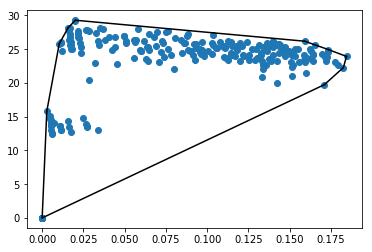

In [27]:
# Example of convex hull
plot_convex_hull(':290051915_0', data_default_roads, y='speed')

### Fundamental diagrams examples

Q0:2.975
Q1:5.050
Q2:5.050
rho0:0.111
rho1:0.200
rho2:0.200
rho*:0.200
free_flow | 0.000:0.200(rho_1)
sync_flow | 0.200(rho_1):0.200(rho_2)
jam_flow  | 0.200(rho_2):0.200(rho_*)


(<Figure size 576x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13ded2950>)

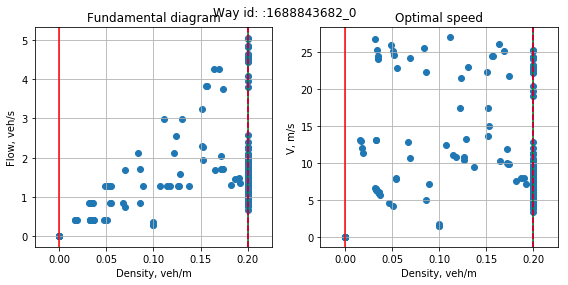

In [28]:
plot_fundamental(':1688843682_0', data_default_roads)

Q0:0.036
Q1:0.072
Q2:0.022
rho0:0.002
rho1:0.006
rho2:0.034
rho*:0.200
free_flow | 0.000:0.006(rho_1)
sync_flow | 0.006(rho_1):0.034(rho_2)
jam_flow  | 0.034(rho_2):0.200(rho_*)


(<Figure size 576x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13df3bf50>)

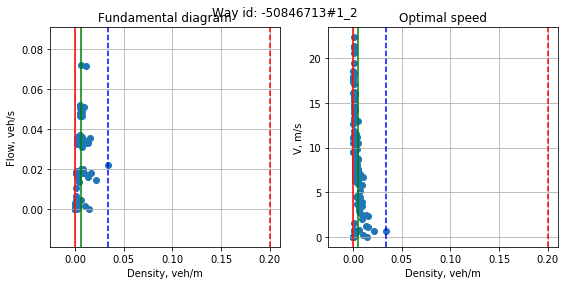

In [29]:
plot_fundamental('-50846713#1_2', data_default_lanes)

### Interpolate function

In [30]:
from scipy.interpolate import UnivariateSpline

In [31]:
def adjust_nonunique_x(a, eps=1e-5):
    uniq, inv, counts = np.unique(a[:, 0], return_counts=True, return_inverse=True)
    for u, c in zip(uniq, counts):
        if c > 1:
            mask = a[:, 0] == u
            non_unique_vals = a[mask]
            non_unique_idx = np.nonzero(mask)[0]
            i = non_unique_idx[non_unique_vals[:, 1].argsort()]
            a = np.delete(a, i[:-1], axis=0)
    return a

In [32]:
import alphashape
import matplotlib.pyplot as plt
from descartes import PolygonPatch

def interpolate_fundamental(way_id, data, y_axis='speed', vis=True, verbose=True):    
    # Calculate fundamental critical points
    rho_0, rho_1, rho_2, rho_max, q_0, q_1, q_2 = get_fundamental(way_id, data, verbose=verbose)

    # Get lane points
    lane = data.loc[way_id]
    points = np.unique(lane[['density', y_axis]].values, axis=0)
    
    # Plot segments
    if vis:
        fig, ax = plt.subplots()
        ax.axvline(x=0, linestyle='-', c='r')
        ax.axvline(x=rho_1, linestyle='-', c='g')
        ax.axvline(x=rho_2, linestyle='--', c='b')
        ax.axvline(x=rho_max, linestyle='--', c='r')
        ax.scatter(points[:, 0], points[:, 1], color='b', s=7)
        ax.set_xlim(0, 0.21)
        ax.set_title(way_id)
    
    # Interpolate by splines
    segments = [(0, rho_1), (rho_1, rho_2), (rho_2, rho_max)]
    all_selected_points = []
    for ind, seg in enumerate(segments):
        seg_points = points[np.where(np.logical_and(points[:, 0] >= seg[0], points[:, 0] <= seg[1]))]
#         print('Segment', seg)
        selected_pts, hull = interpolate_points(seg_points)

        # Add terminal points
        if ind == 2 and not (selected_pts[:, 0] == 0.2).any():
            selected_pts = np.append(selected_pts, [0.2, 0.]).reshape(-1, 2) 
            
#         print('Seg points', np.unique(selected_pts, axis=0))

        # Add last point if necessary
        if len(selected_pts > 0):
            all_selected_points.append(selected_pts)
            if vis:
                if hull is not None:
                    ax.add_patch(PolygonPatch(hull, fill=False, color='green'))
                ax.scatter(selected_pts[:, 0], selected_pts[:, 1], color='red', s=10)
    all_selected_points = np.vstack(all_selected_points)
    all_selected_points = make_increasing_x((all_selected_points[:, 0], all_selected_points[:, 1]))
    spl = UnivariateSpline(all_selected_points[:, 0], all_selected_points[:, 1], k=1, s=0, ext=3)
    # Plot spline
    if vis:
        smooth_x = np.linspace(0, 0.2, 100)
        ax.plot(smooth_x, spl(smooth_x), lw=2, c='m')
    plt.show()
    return spl
        
def make_increasing_x(points):
    # Filter all points which go left (if x(n) < x(n-1))
    x_prev = -1
    y_prev = 1000
    selected_pts = []
    for x, y in zip(*points):
        if x > x_prev:
            x_prev = x
            if y <= y_prev:
                y_prev = y
            else:
                selected_pts.pop(-1)
            selected_pts.append((x, y))
            
    return np.array(selected_pts)
    

def interpolate_points(points):
    # find alpha hull
#     alpha = 0.95 * alphashape.optimizealpha(points)
    if len(np.unique(points, axis=0)) > 2:
        # Build alpha-hull
        if len(np.unique(points[:, 0])) < 2:
            hull_pts = points[:, 0], points[:, 1]
            hull = None
        else:
            alpha = 0.0015
            try:
                hull = alphashape.alphashape(points, alpha=alpha)
                hull_pts = hull.exterior.coords.xy
            except AttributeError:
                print('Cannot find conacave hull, finding the convex hull')
                alpha = 0.
                hull = alphashape.alphashape(points, alpha=alpha)
                hull_pts = hull.exterior.coords.xy
                
        # Get only top points
        x, y = np.array(hull_pts[0]), np.array(hull_pts[1])
        y_max_ind = np.argmax(y)
        potenital_x_max = x == np.max(x)
        most_right = int(np.max(np.nonzero(y == np.max(y[potenital_x_max]))[0]))
        if y_max_ind <= most_right:
            top_points = x[y_max_ind:most_right + 1], y[y_max_ind:most_right + 1]
        else:
            top_points = np.append(x[y_max_ind:-1],  x[:most_right + 1]), np.append(y[y_max_ind:-1], y[:most_right + 1])
    else:
        top_points = points[:, 0], points[:, 1]
        hull = None
    selected_pts = make_increasing_x(top_points)
    return selected_pts, hull

Q0:2.975
Q1:5.050
Q2:5.050
rho0:0.111
rho1:0.200
rho2:0.200
rho*:0.200
free_flow | 0.000:0.200(rho_1)
sync_flow | 0.200(rho_1):0.200(rho_2)
jam_flow  | 0.200(rho_2):0.200(rho_*)


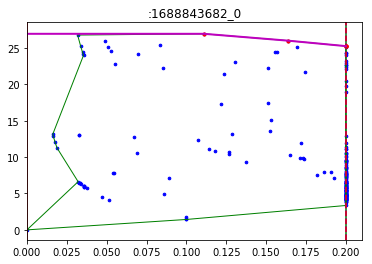

In [33]:
interpolate_fundamental(':1688843682_0', data_default_roads, y_axis='speed')

Q0:0.284
Q1:0.390
Q2:0.390
rho0:0.038
rho1:0.060
rho2:0.060
rho*:0.200
free_flow | 0.000:0.060(rho_1)
sync_flow | 0.060(rho_1):0.060(rho_2)
jam_flow  | 0.060(rho_2):0.200(rho_*)


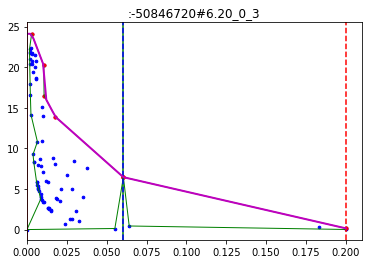

In [34]:
interpolate_fundamental(':-50846720#6.20_0_3', data_default_lanes)

# Different roads

In [35]:
from tqdm.autonotebook import tqdm
def plot_samples(sample_ids, data):
    for sample in tqdm(sample_ids):
        interpolate_fundamental(sample, data, y_axis='speed', vis=True, verbose=False)

/Users/arseniy/miniconda3/envs/tm/lib/python2.7/site-packages/ipykernel_launcher.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """Entry point for launching an IPython kernel.


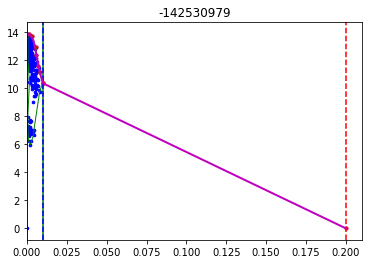

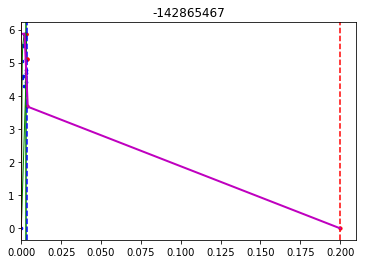

In [36]:
# Plot some roads
plot_samples(ALL_ROADS[1:3], data_default_roads)

## Comparison

Compare the same roads for different roads. Let's take union of top 5 roads by `flow` for each model and compare them

In [37]:
top_roads_default = data_default_roads.groupby('road_id').mean().sort_values('flow', ascending=False).head(10)
top_roads_platoons = data_platoons_roads.groupby('road_id').mean().sort_values('flow', ascending=False).head(10)
top_roads_gm = data_gm_roads.groupby('road_id').mean().sort_values('flow', ascending=False).head(10)

In [38]:
def compare(idx, default, gm, platoons):
    interpolate_fundamental(idx, default, y_axis='speed', vis=True, verbose=False)
    interpolate_fundamental(idx, gm, y_axis='speed', vis=True, verbose=False)
    interpolate_fundamental(idx, platoons, y_axis='speed', vis=True, verbose=False)

In [39]:
idx_for_comparsion = top_roads_default.index.union(top_roads_platoons.index).union(top_roads_gm.index)

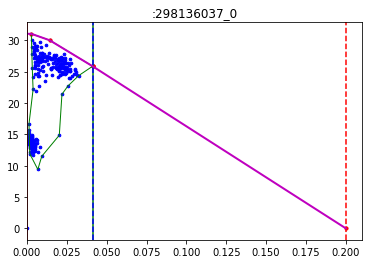

Cannot find conacave hull, finding the convex hull


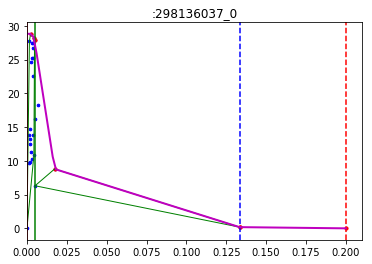

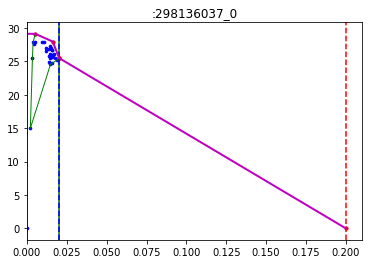

In [40]:
compare(idx_for_comparsion[5], data_default_roads, data_gm_roads, data_platoons_roads)

# Build lane functions

Lane functions to get $dv/d\rho$ for each lane. The functions are estimated by default following model model of SUMO (modified Krauss) and then used in General Motors model to estimate $\alpha$

In [ ]:
from tqdm.autonotebook import tqdm
lane_dvdr = {}
for lane_id in tqdm(ALL_LANES):
    spl = interpolate_fundamental(lane_id, data_default_lanes, y_axis='speed', vis=False, verbose=False)
    lane_dvdr[lane_id] = spl.derivative(1)

In [ ]:
# Check
spl = interpolate_fundamental('gneE17.147_3', data_default_lanes, y_axis='speed', vis=True)
der = spl.derivative(1)
for i in np.linspace(0, 0.2, 20):
    print(der(i))

# Save and load

In [5]:
import pickle

In [ ]:
with open('dvdr.pickle', 'w') as f:
    pickle.dump(lane_dvdr, f)

In [7]:
with open('dvdr_gm.pickle', 'r') as f:
    s = pickle.load(f)

In [47]:
data_default_roads.groupby('road_id').mean().sort_values('density', ascending=False).head(10)

,density,speed,occupancy,flow
road_id,,,,
:1559811808_4,0.195240,0.871833,62.750333,0.145676
:-50846769.75_0,0.159111,2.601937,52.991104,0.141941
:1688843682_0,0.139714,8.500854,4.346938,1.307794
-50846769.75,0.131209,2.602479,50.538646,0.087064
-50846720#0,0.120122,0.784333,58.800708,0.085731
-50846720#6,0.119348,2.731583,41.834292,0.077500
:243728741#3.83_0,0.116855,2.118889,21.437500,0.070366
-50846765,0.112471,2.588292,48.357000,0.072041
:116069075#0.376_0,0.110741,2.623021,40.681760,0.188763


In [57]:
-0.13 * s[':1688843682_0_0'](0.13)

0.8205851774840353

# Our model

In [ ]:
for lane in tqdm(all_lanes[0:20]):
    interpolate_fundamental(lane, data, y_axis='speed', vis=True)

In [ ]:
all_lanes[16]

# Comparison

In [ ]:
from pathlib2 import Path

In [ ]:
p = Path('a/b/c.out')

In [ ]:
os.path.splitext(p.name)

In [ ]:
import os

In [ ]:
os.path.splitext(os.path.basename(p))